# Group Assignment - Data Collection
*by Grace*

## Topic
A machine learning model for predicting the mortality rate for Acute Kidney Injury (AKI) cohort

## This Notebook
This notebook will perform the data collection process based on:
- digital phenotype AKI
- other excluding and including criteria of patient cohort

---

## Project Pipeline
0. **Research**
1. Data collection (**`THIS NOTE`**)
  - Features (this should be decided through research)
  
2. Data preprocessing (**`\notebook\data_preprocessing_AKI.ipynb`**)
  - risk analysis (p value)
  - data balance
  - unification of measurement units (?)
  - removing outliers
  - handling missing values
  - data normalization
3. Modeling - binary classifcation models(**`\notebook\model.ipynb`**)
  - Training
  - Testing
  - Evaluations


# Digital Pheonotype

By [ncbi](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5198510/#:~:text=Acute%20Kidney%20Injury%20(AKI)%20is%20the%20term%20that%20has%20recently,a%20sole%20and%20distinct%20pathophysiology):


- Rise in serum creatinine of ≥ 50% from baseline or
- A rise of serum creatinine by ≥ 26.5 μmol/L (≥ 0.3 mg/dL) in <48 h
- HRS type 1 is a specific form of acute kidney injury

By [uptpdate](https://www.uptodate.com/contents/definition-and-staging-criteria-of-acute-kidney-injury-in-adults?search=Acute%20Kidney%20Injury&source=search_result&selectedTitle=3~150&usage_type=default&display_rank=2):

The KDIGO guidelines define AKI as follows [1]:

- Increase in serum creatinine by ≥0.3 mg/dL (≥26.5 micromol/L) within 48 hours, or
- Increase in serum creatinine to ≥1.5 times baseline, which is known or presumed to have occurred within the prior seven days, or
- Urine volume <0.5 mL/kg/hour for six hours


In [2]:
# Import libraries

import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery
# authenticate
auth.authenticate_user()
# Set up environment variables
project_id = 'CHANGE-ME' #JUST CHANGE THIS VARIABLE
if project_id == 'CHANGE-ME': #DON'T CHANGE THIS ONE.
  raise ValueError('You must change project_id to your GCP project.')
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id



# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

dataset = 'mimiciv'


In [3]:
df = run_query("""
SELECT *
FROM `physionet-data.mimiciv_icu.d_items`
WHERE LOWER(label) LIKE '%urine%';

""")
df
# 226566: Urine and GU Irrigant Out
# 227519: Urine output_ApacheIV

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,225454,Urine Culture,Urine Culture,procedureevents,6-Cultures,None,Processes,NaN,NaN
1,220799,ZSpecific Gravity (urine),ZSpecific gravity (urine),chartevents,Labs,None,Numeric,NaN,NaN
2,227471,Specific Gravity (urine),Specific Gravity (urine),chartevents,Labs,None,Numeric with tag,NaN,NaN
3,224015,Urine Source,Urine Source,chartevents,GI/GU,None,Text,NaN,NaN
4,224016,Urine Color,Urine Color,chartevents,GI/GU,None,Text,NaN,NaN
5,224876,Urine Appearance,Urine Appearance,chartevents,GI/GU,None,Text,NaN,NaN
6,226566,Urine and GU Irrigant Out,Urine and GU Irrigant Out,outputevents,Output,mL,Numeric,NaN,NaN
7,226627,OR Urine,OR Urine,outputevents,Output,mL,Numeric,NaN,NaN
8,226631,PACU Urine,PACU Urine,outputevents,Output,mL,Numeric,NaN,NaN
9,227489,GU Irrigant/Urine Volume Out,GU Irrigant/Urine Volume Out,outputevents,Output,mL,Numeric,NaN,NaN


In [ ]:
query = f"""
SELECT *
FROM `physionet-data.mimiciv_hosp.d_labitems`
WHERE LOWER(label) LIKE '%creatinine%'
"""
df = run_query(query)
print(df)
# 50912                       Creatinine                Blood  Chemistry

    itemid                            label                fluid   category
0    52024          Creatinine, Whole Blood                Blood  Blood Gas
1    50912                       Creatinine                Blood  Chemistry
2    52546                       Creatinine                Blood  Chemistry
3    51937                Creatinine, Stool                Stool  Chemistry
4    51067                 24 hr Creatinine                Urine  Chemistry
5    51070        Albumin/Creatinine, Urine                Urine  Chemistry
6    51073  Amylase/Creatinine Ratio, Urine                Urine  Chemistry
7    51080             Creatinine Clearance                Urine  Chemistry
8    51081                Creatinine, Serum                Urine  Chemistry
9    51082                Creatinine, Urine                Urine  Chemistry
10   51099         Protein/Creatinine Ratio                Urine  Chemistry
11   51106                 Urine Creatinine                Urine  Chemistry
12   51963  

In [ ]:
## find weight

#weight_df = run_query("""
#SELECT DISTINCT itemid, label
#FROM `physionet-data.mimiciv_hosp.d_items`
#WHERE LOWER(label) LIKE '%weight%'

#""")

# no access to patient's weight

In [4]:
query = f"""
SELECT
    COUNT(DISTINCT subject_id) AS total_unique_patients,
    COUNT(DISTINCT hadm_id) AS total_admissions
FROM `physionet-data.mimiciv_hosp.admissions`;
"""
pt3 = run_query(query)
pt3

,total_unique_patients,total_admissions
0,180733,431231


# Exclude Unintended Patients
Discover the overall mortality rate of ICU patient

In [5]:
query = f"""
WITH MortalityData AS (
    SELECT
        icu.subject_id,
        CASE
            WHEN pt.dod IS NOT NULL AND DATE(pt.dod) <= DATE(icu.outtime) THEN 1
            ELSE 0
        END AS mortality
    FROM `physionet-data.mimiciv_icu.icustays` AS icu
    INNER JOIN `physionet-data.mimiciv_hosp.patients` AS pt ON icu.subject_id = pt.subject_id
    GROUP BY icu.subject_id, pt.dod, icu.outtime
)

SELECT
    COUNT(DISTINCT subject_id) AS total_unique_icu_patients,
    SUM(mortality) AS total_deceased_patients,
    (SUM(mortality) * 100.0 / COUNT(DISTINCT subject_id)) AS mortality_rate_percent
FROM MortalityData
"""
# exlude 10848 patient whose dod is after leaving ICU
pt3 = run_query(query)
pt3

,total_unique_icu_patients,total_deceased_patients,mortality_rate_percent
0,50920,5629,11.054595


In [6]:
query = f"""
WITH Total_ICU_Patients AS (
    SELECT DISTINCT subject_id
    FROM `physionet-data.mimiciv_icu.icustays`
),

-- Patients with single ICU stay
Single_ICU_Stay AS (
    SELECT
        subject_id,
        COUNT(*) AS num_admissions,
        AVG(los) AS avg_los
    FROM `physionet-data.mimiciv_icu.icustays`
    GROUP BY subject_id
    HAVING num_admissions = 1
),

-- Patients with avg ICU stay > 1 day
Filtered_ICU_Stay_Greater_Los AS (
    SELECT
        s.subject_id
    FROM Single_ICU_Stay AS s
    WHERE s.avg_los > 1
),

-- Patients aged 18 or older
Filtered_ICU_Stay_Aged_18 AS (
    SELECT
        s.subject_id
    FROM Filtered_ICU_Stay_Greater_Los AS s
    INNER JOIN `physionet-data.mimiciv_hosp.patients` AS p ON s.subject_id = p.subject_id
    WHERE p.anchor_age >= 18
),

-- Patients aged 18 or older with creatinine labels
Patients_Aged_18_With_Creatinine AS (
    SELECT DISTINCT
        f.subject_id
    FROM Filtered_ICU_Stay_Aged_18 AS f
    INNER JOIN `physionet-data.mimiciv_hosp.labevents` AS le ON f.subject_id = le.subject_id
    WHERE le.itemid = 50912
    AND le.valuenum IS NOT NULL
),

MortalityDataPostICU AS (
    SELECT
        icu.subject_id,
        CASE
            WHEN pt.dod IS NOT NULL AND DATE(pt.dod) > DATE(icu.outtime) THEN 1
            ELSE 0
        END AS mortality_post_icu
    FROM `physionet-data.mimiciv_icu.icustays` AS icu
    INNER JOIN `physionet-data.mimiciv_hosp.patients` AS pt ON icu.subject_id = pt.subject_id
    WHERE icu.subject_id IN (SELECT subject_id FROM Patients_Aged_18_With_Creatinine)
    GROUP BY icu.subject_id, pt.dod, icu.outtime
)


-- Final counts
SELECT
    (SELECT COUNT(*) FROM Total_ICU_Patients) AS total_icu_patients,
    (SELECT COUNT(*) FROM Single_ICU_Stay) AS patients_single_stay,
    (SELECT COUNT(*) FROM Filtered_ICU_Stay_Greater_Los) AS patients_greater_than_1_day,
    (SELECT COUNT(*) FROM Filtered_ICU_Stay_Aged_18) AS patients_aged_18_or_older,
    (SELECT COUNT(*) FROM Patients_Aged_18_With_Creatinine) AS patients_aged_18_with_creatinine,
    SUM(mortality_post_icu) AS patients_aged_18_with_creatinine_posticudeath
    FROM MortalityDataPostICU
"""
pt3 = run_query(query)
pt3


,total_icu_patients,patients_single_stay,patients_greater_than_1_day,patients_aged_18_or_older,patients_aged_18_with_creatinine,patients_aged_18_with_creatinine_posticudeath
0,50920,38472,30290,30290,30272,5595


## Comments
Up to here we excluded these patients:
- 12,448 patients were filtered out because they had more than one ICU stay.
- 8,182 patients were filtered out because their average ICU stay was 1 day or less.
- No additional patients were filtered out based on age since all the remaining patients were already 18 years or older.
- 18 patients with no creatinine label

## Digital Phenotype of AKI

In [7]:
# patient with creatinine measurements
query = f"""
SELECT
    le.subject_id,
    COUNT(*) AS creatinine_measurements
FROM `physionet-data.mimiciv_hosp.labevents` AS le
WHERE le.itemid = 50912
GROUP BY le.subject_id
"""
df = run_query(query)
print(f'{len(df)} patients with serum creatinine measurements in labevents')
creatinine_whole_cohort = len(df)

239869 patients with serum creatinine measurements in labevents


In [8]:
# patient with creatinine measurements & has record cross the required timeframe based on AKI diagnostic criteria

query = f"""
WITH Single_ICU_Stay AS (
    SELECT
        subject_id,
        COUNT(*) AS num_admissions,
        AVG(los) AS avg_los
    FROM `physionet-data.mimiciv_icu.icustays`
    GROUP BY subject_id
    HAVING num_admissions = 1
),

Filtered_ICU_Stay AS (
    SELECT
        subject_id
    FROM Single_ICU_Stay
    WHERE avg_los > 1
),

Creatinine_Values AS (
    SELECT
        le.subject_id,
        le.charttime,
        le.valuenum AS creatinine_value,
        LAG(le.valuenum) OVER (PARTITION BY le.subject_id ORDER BY le.charttime) AS previous_creatinine_value,
        LAG(le.charttime) OVER (PARTITION BY le.subject_id ORDER BY le.charttime) AS previous_charttime
    FROM `physionet-data.mimiciv_hosp.labevents` AS le
    WHERE le.itemid = 50912
    AND le.valuenum IS NOT NULL
)

SELECT
    cv.subject_id,
    COUNT(DISTINCT CASE WHEN cv.creatinine_value - cv.previous_creatinine_value >= 0.3
                             AND TIMESTAMP_DIFF(cv.charttime, cv.previous_charttime, HOUR) <= 48
                        THEN cv.subject_id END) AS AKI_criterion1_patients,
    COUNT(DISTINCT CASE WHEN cv.creatinine_value >= 1.5 * cv.previous_creatinine_value
                             AND TIMESTAMP_DIFF(cv.charttime, cv.previous_charttime, HOUR) <= 168 -- 7 DAYS
                        THEN cv.subject_id END) AS AKI_criterion2_patients,
    COUNT(DISTINCT CASE WHEN pt.dod IS NOT NULL AND DATE(pt.dod) <= DATE(icu.outtime) THEN cv.subject_id END) AS deceased_patients

FROM Creatinine_Values AS cv
INNER JOIN `physionet-data.mimiciv_hosp.patients` as pt ON cv.subject_id = pt.subject_id
INNER JOIN Filtered_ICU_Stay AS fis ON cv.subject_id = fis.subject_id
INNER JOIN `physionet-data.mimiciv_icu.icustays` AS icu ON cv.subject_id = icu.subject_id  -- Added this line to join with icustays
GROUP BY cv.subject_id, pt.dod, icu.outtime;
"""
pt = run_query(query)
print(f'{len(pt)} patients identified based on AKI criteria in labevents using itemid 50912')


30272 patients identified based on AKI criteria in labevents using itemid 50912


In [9]:
pt

,subject_id,AKI_criterion1_patients,AKI_criterion2_patients,deceased_patients
0,10462540,0,0,0
1,11297138,0,0,0
2,12097837,0,0,0
3,15262879,0,0,0
4,15784702,0,1,0
...,...,...,...,...
30267,13566912,1,0,0
30268,15462355,1,0,0
30269,11131026,1,0,0
30270,18470025,1,0,0


In [10]:
## Filter patients based on AKI criteria
pt_aki = pt[(pt['AKI_criterion1_patients'] == 1) | (pt['AKI_criterion2_patients'] == 1)]

# Calculate mortality rate among AKI patients
aki_mortality_rate = round(len(pt_aki[pt_aki['deceased_patients'] == 1]) / len(pt_aki) * 100, 2)

print(f'Among the {len(pt)} patients with serum creatinine measurements, {len(pt_aki)} ({round(len(pt_aki)/len(pt)*100,2)}%) satisfy the AKI criteria based on serum creatinine changes.')
print(f'Among the {len(pt_aki)} AKI patients, {aki_mortality_rate}% deceased.')


Among the 30272 patients with serum creatinine measurements, 9810 (32.41%) satisfy the AKI criteria based on serum creatinine changes.
Among the 9810 AKI patients, 16.9% deceased.


In [11]:
pt_aki
# through our digital phenotype, 9432 patient satisfy the diagnostic criteria of AKI.

,subject_id,AKI_criterion1_patients,AKI_criterion2_patients,deceased_patients
4,15784702,0,1,0
44,13889326,0,1,0
64,17535980,0,1,0
79,14246655,0,1,0
84,13582085,0,1,0
...,...,...,...,...
30267,13566912,1,0,0
30268,15462355,1,0,0
30269,11131026,1,0,0
30270,18470025,1,0,0


In [12]:
pt_aki.to_csv('dod.csv')

In [13]:
subject_ids_str = ', '.join(map(str, pt_aki['subject_id']))


## Features (Risk Factors)

[UptoDate](https://www.uptodate.com/contents/kidney-and-patient-outcomes-after-acute-kidney-injury-in-adults?search=acute%20kidney%20injury%20risk%20factor&source=search_result&selectedTitle=1~150&usage_type=default&display_rank=1)


Acute Kidney Injury (AKI) is a complex condition with multiple potential causes and risk factors. When studying AKI, it's essential to consider both traditional risk factors and those specific to the ICU setting.

### 1. **Patients' Demographics**:
- **Age**: Older age is a known risk factor for AKI.
- **Gender**: Some studies suggest gender differences in AKI incidence.
- **Comorbidities**: Conditions like diabetes, hypertension, and chronic kidney disease increase the risk of AKI.

### 2. **Clinical Measurements**:
- **Blood Pressure (SBP & DBP)**: Hypotension is a significant risk factor for AKI, especially in the ICU setting.
- **Heart Rate (HR)**: Tachycardia or bradycardia can be indicators of underlying conditions that predispose to AKI.
- **Respiratory Rate (RR)**: Respiratory issues can lead to hypoxia, which can cause AKI.
- **Temperature**: Fever can be a sign of infections, which can lead to sepsis-associated AKI.
- **SPO2**: Low oxygen saturation can indicate hypoxia, a risk factor for AKI.
- **Fluid Balance**: Positive fluid balance, especially in the ICU, is associated with AKI.
- **Severity of Illness Scores (e.g., APSIII, OASIS, SOFA)**: Higher severity scores often correlate with a higher risk of AKI.

### 3. **Lab Measurements**:
- **Baseline Creatinine**: To determine the increase from the baseline, which is crucial for AKI diagnosis.
- **Urine Output**: A decrease in urine output is a diagnostic criterion for AKI.
- **Electrolytes**: Especially potassium and sodium, as imbalances can be both a cause and a result of AKI.
- **BUN (Blood Urea Nitrogen)**: Elevated levels can indicate reduced kidney function.
- **Albumin**: Low levels can indicate nephrotic syndrome or malnutrition, both of which can be risk factors for AKI.
- **Hemoglobin**: Anemia can be a risk factor for AKI.
- **WBC**: Elevated levels can indicate infection, a significant cause of AKI in the ICU.
- **INR, PT, APTT**: Coagulation abnormalities can be associated with AKI, especially in conditions like disseminated intravascular coagulation (DIC).


When studying AKI, it's also essential to consider the temporal aspect, as AKI can be a rapidly evolving condition. Monitoring changes in the above parameters over time can provide valuable insights into the onset and progression of AKI.

### 1. **Patients' Demographics**
- Tables: **`mimiciv_core.patients`** and **`mimiciv_core.admissions`**
- Variables: **`Gender`**, **`Comorbidity`**, **`Age`**

In [14]:
# Convert the 'subject_id' column to a list
subject_ids = pt_aki['subject_id'].tolist()

# Convert the list to a comma-separated string
subject_ids_str = ', '.join(map(str, subject_ids))

# Use the formatted string in our SQL query
query = f"""
SELECT
    p.subject_id,
    p.gender,
    p.anchor_age
FROM
    `physionet-data.mimiciv_hosp.patients` AS p
WHERE
    p.subject_id IN ({subject_ids_str})

"""

demographic = run_query(query)
demographic

,subject_id,gender,anchor_age
0,10352416,M,23
1,16617539,M,23
2,11895707,M,24
3,13299333,F,24
4,16154757,F,28
...,...,...,...
9805,10096420,M,65
9806,16262919,F,81
9807,19149321,M,53
9808,12684652,M,86


In [15]:
len(demographic[demographic['anchor_age'] >= 18]) # all patients are adult

9810

In [17]:
# Generate binary indicators for each comorbidity using ICD
# example: diabetes (0:no 1:yes)

subject_ids = pt_aki['subject_id'].tolist()
subject_ids_str = ', '.join(map(str, subject_ids))

comorbidity_query = f"""
SELECT subject_id,
       MAX(CASE WHEN icd_code LIKE '250%' OR icd_code LIKE 'E1[0-4]%' THEN 1 ELSE 0 END) AS diabetes,
       MAX(CASE WHEN icd_code LIKE '401%' OR icd_code LIKE 'I10%' THEN 1 ELSE 0 END) AS hypertension,
       MAX(CASE WHEN icd_code LIKE '585%' OR icd_code LIKE 'N18%' THEN 1 ELSE 0 END) AS chronic_kidney_disease,
       MAX(CASE WHEN icd_code LIKE 'A40%' OR icd_code LIKE 'A41%' THEN 1 ELSE 0 END) AS sepsis
FROM `physionet-data.mimiciv_hosp.diagnoses_icd`
WHERE subject_id IN ({subject_ids_str})
GROUP BY subject_id
"""

comorbidity_patients = run_query(comorbidity_query)

# Fetching demographic details with comorbidity indicators
query = f"""
SELECT
    p.subject_id,
    IFNULL(c.diabetes, 0) AS diabetes,
    IFNULL(c.hypertension, 0) AS hypertension,
    IFNULL(c.chronic_kidney_disease, 0) AS chronic_kidney_disease,
    IFNULL(c.sepsis, 0) AS sepsis
FROM
    `physionet-data.mimiciv_hosp.patients` AS p
LEFT JOIN
    ({comorbidity_query}) AS c
ON
    p.subject_id = c.subject_id
WHERE
    p.subject_id IN ({subject_ids_str})
"""

demographic_with_indicators = run_query(query)
demographic_with_indicators.to_csv('comorbidity.csv')


### 2. **Clinical Measurements**:
- Table: `physionet-data.mimiciv_icu.d_items`
  - Variables: **Blood Pressure (SBP & DBP)**: Hypotension is a significant risk factor for AKI, especially in the ICU setting.

- Table: **`mimiciv_icu.chartevents`**
  - Variables: **`HR`**, **`SBP`**, **`DBP`**, **`RR`**, **`Temperature`**, **`SPO2`**, etc.

| Feature                             | ItemID | Description |
|------------------------------------|--------|-------------|
| Heart rate (HR)                    | 220045 | Tachycardia or bradycardia may indicate conditions leading to AKI. |
| Systolic blood pressure (SBP)      | 220050 | Hypotension is a significant risk factor for AKI, especially in the ICU setting. |
| Diastolic blood pressure (DBP)     | 220051 | Hypotension is a significant risk factor for AKI, especially in the ICU setting. |
| Respiratory rate (RR)              | 220210 | Respiratory complications can result in hypoxia, a potential cause of AKI. |
| Heart rate Alarm - High            | 220046 | Alarm for high heart rate. |
| HrApacheIIScore                    | 226763 | Apache II Scoring system related to heart rate. |
| RR > 35 for > 5 min                | 224718 | Extended period of high respiratory rate. |
| SPO                                | 226253 | Low oxygen saturation can be a sign of hypoxia, a risk factor for AKI. |
|Temperature Celsius	|223762	|Fever may suggest infections, which can progress to sepsis-associated AKI.|

---


### 3. **Lab Measurements**:

  - Table: **`mimiciv_icu.labevents`**



| itemid | label                       | Description                                                          |
|--------|-----------------------------|----------------------------------------------------------------------|
| 50811  | Hemoglobin                  | Anemia can be a risk factor for AKI.                                 |
| 50833  | Potassium                   | Electrolytes: Especially potassium and sodium, as imbalances can be both a cause and a result of AKI. |
| 50862  | Albumin                     | Albumin: Low levels can indicate nephrotic syndrome or malnutrition, both of which can be risk factors for AKI. |
| 50912  | Creatinine                  | Baseline Creatinine: To determine the increase from the baseline, which is crucial for AKI diagnosis. |
| 51237  | INR(PT)                     | INR, PT, APTT: Coagulation abnormalities can be associated with AKI, especially in conditions like disseminated intravascular coagulation (DIC). |
| 50983  | Sodium                      | Electrolytes: Especially potassium and sodium, as imbalances can be both a cause and a result of AKI. |
| 51006  | Urea Nitrogen               | BUN (Blood Urea Nitrogen): Elevated levels can indicate reduced kidney function. |
| 51070  | Albumin/Creatinine, Urine   | Urine Output: A decrease in urine output is a diagnostic criterion for AKI. |
| 51274  | PT                          | INR, PT, APTT: Coagulation abnormalities can be associated with AKI, especially in conditions like disseminated intravascular coagulation (DIC). |
| 52407  | WBC                         | WBC: Elevated levels can indicate infection, a significant cause of AKI in the ICU. |
| 52022  | Albumin, Blood              | Measures albumin levels in blood, which can indicate overall health and nutrition. |
| 51006  | Urea Nitrogen               | Evaluates kidney function; high levels can indicate reduced kidney function. |
| 226566 | Urine and GU Irrigant Out   | Measures the volume of removed urine and irrigation fluids during genitourinary procedures. |
| 227519 | Urine output_ApacheIV       | Tracks urine output, important for assessing acute kidney injury (AKI) in ICU patients. |



In [27]:
query = f"""
SELECT itemid, label
FROM `physionet-data.mimiciv_icu.d_items`
WHERE
    LOWER(label) LIKE 'heart rate%' OR
    LOWER(label) LIKE 'hr%' OR
    LOWER(label) LIKE '%blood pressure systolic' OR
    LOWER(label) LIKE '%blood pressure diastolic' OR
    LOWER(label) LIKE 'respiratory rate%' OR
    LOWER(label) LIKE 'rr%' OR
    LOWER(label) LIKE 'spo%' OR
    LOWER(label) LIKE 'temperature%'
ORDER BY label;
"""

Clinical_Measurements = run_query(query)

In [20]:
!pip install thefuzz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 28.6 MB/s eta 0:00:00


In [22]:
import pandas as pd
from thefuzz import process

lab_items = [
    'Baseline Creatinine',
    'Urine Output',
    'Potassium',
    'Sodium',
    'BUN (Blood Urea Nitrogen)',
    'Albumin',
    'Hemoglobin',
    'WBC',
    'INR',
    'PT',
    'APTT'
]

# Load the lab items from the MIMIC-IV dataset
query = f"""
SELECT *
FROM physionet-data.mimiciv_hosp.d_labitems
"""
d_labitems = run_query(query)

# Save the lab items to a CSV file for reference
d_labitems.to_csv('lab_items.csv')

# Create a dictionary to store matching lab items
matching_lab = {}

# Find the best match for each lab item
for word in lab_items:
    best_match, score = process.extractOne(word, list(d_labitems['label']))

    # Create the similarity threshold as 80
    if score > 80:
        matching_lab[word] = best_match

# Print the matching lab items
print("Matching Lab Items:")
print(matching_lab)

# Extract the matching lab item values
matching_lab_values = list(matching_lab.values())

# Filter the lab items based on the matching lab item values
filtered_labitems = d_labitems[d_labitems['label'].isin(matching_lab_values)]
filtered_labitems = filtered_labitems.drop_duplicates(subset='label', keep='first')

# Print the filtered lab items
print("\nFiltered Lab Items:")
print(filtered_labitems)

# Extract the item IDs of the filtered lab items
labitems_ids = filtered_labitems['itemid'].tolist()

# Create a comma-separated string of item IDs for further use
labitems_str = ', '.join(map(str, labitems_ids))

# Print the number of filtered lab items
print(f"\nNumber of Filtered Lab Items: {len(filtered_labitems)}")


Matching Lab Items:
{'Baseline Creatinine': 'Creatinine', 'Urine Output': 'Albumin/Creatinine, Urine', 'Potassium': 'Potassium', 'Sodium': 'Sodium', 'BUN (Blood Urea Nitrogen)': 'Urea Nitrogen', 'Albumin': 'Albumin', 'Hemoglobin': 'Hemoglobin', 'WBC': 'WBC', 'INR': 'I', 'PT': 'PT', 'APTT': 'PT'}

Filtered Lab Items:
      itemid                      label             fluid    category
14     50811                 Hemoglobin             Blood   Blood Gas
61     50833                  Potassium  Other Body Fluid   Blood Gas
74     50862                    Albumin             Blood   Chemistry
124    50912                 Creatinine             Blood   Chemistry
158    50947                          I             Blood   Chemistry
194    50983                     Sodium             Blood   Chemistry
216    51006              Urea Nitrogen             Blood   Chemistry
523    51070  Albumin/Creatinine, Urine             Urine   Chemistry
993    51274                         PT             

In [23]:
# through above analysis, we can conclude the needed itemid as follow:
clinical_str = "220045, 220050, 220051, 220210, 220046, 226763, 224718, 226253, 223762"
labitems_str = "50811, 50833, 50862, 50912, 51237, 50983, 51006, 51070, 51274, 52407, 52022, 51006, 226566, 227519"


In [24]:
subject_ids_str

'15784702, 13889326, 17535980, 14246655, 13582085, 10373251, 10276690, 16683000, 12157912, 12772855, 11644013, 18750949, 18755721, 15697370, 13985661, 11863409, 19874138, 17827950, 11871815, 14426611, 19725697, 11553202, 19458578, 19265997, 18158494, 19206592, 15640315, 16920636, 10958187, 15530412, 15665863, 11191482, 18398182, 17114936, 14614500, 12441917, 17976632, 18071267, 19039643, 18125751, 12267491, 19760462, 11233081, 12282476, 16323001, 10253803, 10920214, 19330161, 17854409, 11019502, 12317014, 12240639, 16520274, 18938959, 12952402, 12177539, 11161741, 15895049, 17967763, 10377744, 16162295, 11259141, 18287878, 18574594, 14363499, 18153015, 15449698, 13792998, 14872473, 17135977, 14021871, 17088659, 12213726, 17074525, 15426443, 15703542, 17972219, 13043906, 16560392, 19942060, 13954025, 17167982, 18261175, 10122182, 12629647, 15686002, 18300625, 15928868, 10595935, 18416632, 10270170, 13498162, 15953468, 10862235, 19233678, 18212567, 16851547, 10839115, 15001570, 11476905,

In [25]:
# extract the dataframe for patient with required lab feature
query = f"""
WITH RankedEvents AS (
    SELECT
        le.subject_id AS subject_id,
        p.gender AS gender,
        p.anchor_age AS age,
        p.dod AS dod,
        l.itemid AS lab_itemid,
        l.label AS lab_label,
        le.valuenum AS lab_val,
        le.valueuom AS lab_unit,
        ROW_NUMBER() OVER(PARTITION BY le.subject_id, l.label ORDER BY le.itemid) AS rn
    FROM
        `physionet-data.mimiciv_hosp.labevents` AS le
    JOIN
        `physionet-data.mimiciv_hosp.d_labitems` AS l
        ON l.itemid = le.itemid

    JOIN
        `physionet-data.mimiciv_hosp.patients` AS p
        ON le.subject_id = p.subject_id
    WHERE le.itemid in ({labitems_str}) AND le.subject_id IN ({subject_ids_str})
    )

SELECT
    subject_id,
    gender,
    age,
    lab_label,
    lab_itemid,
    lab_val,
    lab_unit,
    dod
FROM
    RankedEvents
WHERE
    rn = 1
"""

lab_df = run_query(query)

lab_df.to_csv('lab_df.csv')

In [26]:
# extract the dataframe for patient with required clinical feature

query = f"""
WITH RankedEvents AS (
    SELECT
        ce.subject_id AS subject_id,
        p.gender AS gender,
        p.anchor_age AS age,
        p.dod AS dod,
        c.itemid AS clinic_itemid,
        c.label AS clinic_label,
        ce.valuenum AS clinic_val,
        ce.valueuom AS clinic_unit,
        ROW_NUMBER() OVER(PARTITION BY ce.subject_id, c.label ORDER BY ce.itemid) AS rn
    FROM
        `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN
        `physionet-data.mimiciv_icu.d_items` AS c
        ON c.itemid = ce.itemid
    JOIN
        `physionet-data.mimiciv_hosp.patients` AS p
        ON ce.subject_id = p.subject_id
    WHERE ce.itemid in ({clinical_str}) AND
      ce.subject_id IN ({subject_ids_str})
    )

SELECT
    subject_id,
    gender,
    age,
    clinic_itemid,
    clinic_label,
    clinic_val,
    clinic_unit,
    dod
FROM
    RankedEvents
WHERE
    rn = 1
"""

clinic_df = run_query(query)

clinic_df.to_csv('clinic_df.csv')

In [28]:
clinic_df.subject_id.unique() #double check

<IntegerArray>
[18539548, 14246655, 19305113, 16665617, 11164848, 15274195, 10331694,
 10774186, 12505045, 12661536,
 ...
 19076225, 19122973, 19187556, 19249278, 19411951, 19558986, 19609140,
 19678950, 11984674, 10501258]
Length: 9810, dtype: Int64

In [29]:
lab_df.subject_id.unique() #double check

<IntegerArray>
[10044916, 10141243, 10232572, 10529596, 10614428, 10636690, 10683325,
 10712217, 10954531, 10989760,
 ...
 15707530, 11403650, 17694801, 10501044, 14597090, 11803171, 19086478,
 19458616, 10560480, 19045194]
Length: 9810, dtype: Int64

## EDA with extracted data
For now, our data looks like:

In [30]:
lab_df

,subject_id,gender,age,lab_label,lab_itemid,lab_val,lab_unit,dod
0,10044916,M,55,PT,51274,11.1,sec,NaT
1,10141243,M,77,PT,51274,13.1,sec,NaT
2,10232572,F,37,PT,51274,9.6,sec,NaT
3,10529596,F,91,PT,51274,12.2,sec,NaT
4,10614428,F,61,PT,51274,11.2,sec,2111-06-06
...,...,...,...,...,...,...,...,...
64689,16934035,M,64,"Albumin/Creatinine, Urine",51070,2.2,mg/g,NaT
64690,17191559,F,44,"Albumin/Creatinine, Urine",51070,2270.0,mg/g,NaT
64691,18713335,F,68,"Albumin/Creatinine, Urine",51070,33.3,mg/g,NaT
64692,19259992,M,57,"Albumin/Creatinine, Urine",51070,NaN,mg/g,NaT


where each row is the different clinical/lab feature. In the end, we want a data frame where all demographic, clinical, and lab information of ONE individual is listed in ONE row for statistical analysis convinience.

So the final dataframe should be in the size of 9344 * n where 9434 is the number of AKI cohort and n is the number of demographic + clinical + lab features.

In [31]:
lab_df.columns

Index(['subject_id', 'gender', 'age', 'lab_label', 'lab_itemid', 'lab_val',
       'lab_unit', 'dod'],
      dtype='object')

In [32]:
unique_label_counts = lab_df.groupby('subject_id')['lab_label'].nunique().reset_index()

# Rename the column to make it clear
unique_label_counts.columns = ['subject_id', 'unique_label_count']

# Display the table
print(unique_label_counts)

count_of_individuals = unique_label_counts['unique_label_count'].value_counts().reset_index()

# Rename the columns for clarity
count_of_individuals.columns = ['unique_label_count', 'count_of_individuals']

# Display the table
print(count_of_individuals)

      subject_id  unique_label_count
0       10002013                   8
1       10002430                   7
2       10002760                   7
3       10004235                   7
4       10004457                   7
...          ...                 ...
9805    19995258                   7
9806    19995595                   7
9807    19997752                   7
9808    19999297                   6
9809    19999828                   6

[9810 rows x 2 columns]
   unique_label_count  count_of_individuals
0                   7                  4998
1                   6                  3537
2                   8                   715
3                   5                   534
4                   4                    18
5                   3                     8


By the struture of our current dataframe, we can infer that the number of appearance of subject_id refers to the clinical/lab feature an individual have. Therefore, we can compose the following graph to get an intuition of missing vlaue distribution (as some individual may miss some features)

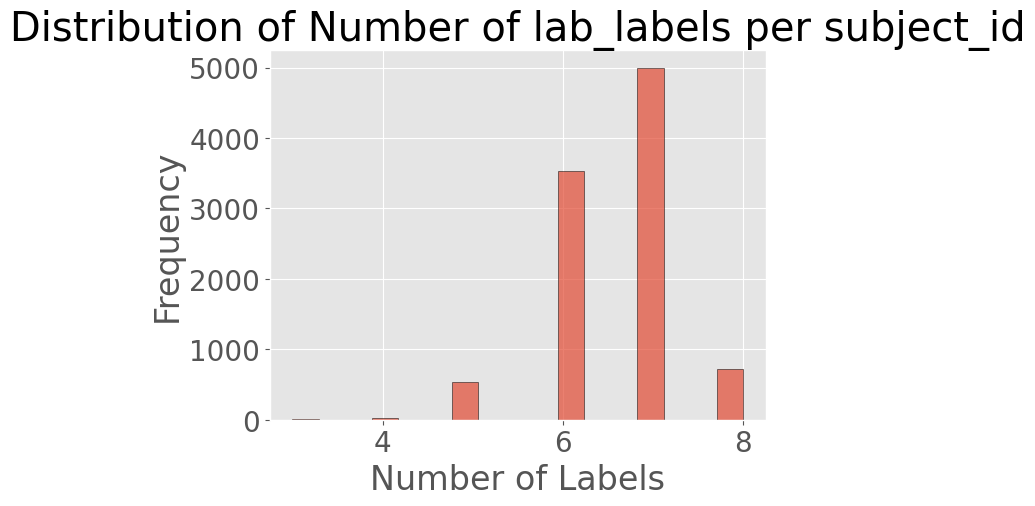

In [33]:
# Create a histogram to visualize the distribution of the number of labels
label_counts = lab_df['subject_id'].value_counts()
plt.hist(label_counts, bins=17, edgecolor='k', alpha=0.7)
plt.xlabel("Number of Labels")
plt.ylabel("Frequency")
plt.title("Distribution of Number of lab_labels per subject_id")
plt.show()

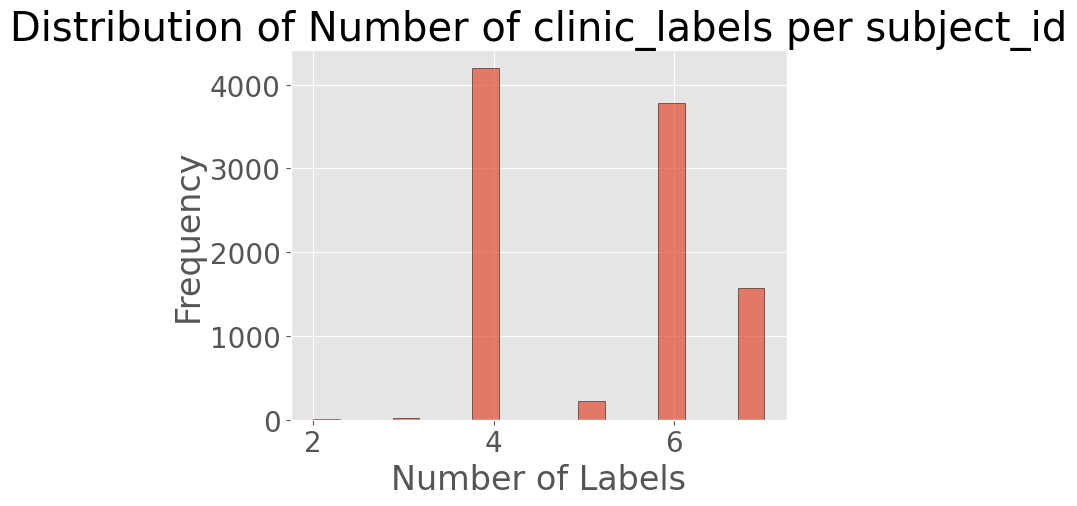

In [34]:
# Create a histogram to visualize the distribution of the number of labels
clinic_counts = clinic_df['subject_id'].value_counts()
plt.hist(clinic_counts, bins=17, edgecolor='k', alpha=0.7)
plt.xlabel("Number of Labels")
plt.ylabel("Frequency")
plt.title("Distribution of Number of clinic_labels per subject_id")
plt.show()

The above suggests that most AKI patiens have 7-8 labe labels; and 4 or 6 clinical labels which suggest that majority patient have the most labels. This indicates that our data can be good to train the model if we apply appropriate deletion, imputation methods etc.


---
Some additional notes for missing value imputation
1. **Understanding the Nature of Missingness**: Before deciding how to deal with the missing values, it's essential to understand why data might be missing. There are three main types of missing data:
   - **MCAR** (Missing Completely at Random): The missingness is not related to any other variable.
   - **MAR** (Missing at Random): The probability of missingness is related to some observed data but not the missing data itself.
   - **MNAR** (Missing Not at Random): The missingness is related to the missing data itself or some unobserved data.

2. **Deletion Methods**:
   - **Listwise Deletion (Complete Case Analysis)**: Exclude any case (or row) that has a missing value. This method is simple but can lead to loss of data, reducing statistical power.
   - **Pairwise Deletion**: Use all available data for each analysis. It maximizes the data available but can lead to inconsistency.

3. **Imputation Methods**:
   - **Mean/Median/Mode Imputation**: Replace missing values with the mean, median, or mode of the observed values. This can reduce variability and lead to underestimation of standard errors.
   - **Linear Regression Imputation**: Predict the missing value using a regression model.
   - **Multiple Imputation**: Multiple datasets are created, imputed, and analyzed. The results are then pooled to give estimates and confidence intervals.

4. **Advanced Methods**:
   - **Model-Based Methods**: Assumes that the data comes from a specific type of model, like Maximum Likelihood Estimation for normally distributed data.
   - **Machine Learning Methods**: Techniques like k-Nearest Neighbors can be used to predict and impute missing values.

5. **Sensitivity Analysis**: If we suspect that data might be MNAR, then a sensitivity analysis can help assess how sensitive our results are to the way we've handled the missing data.

Before deciding which method to use, consider the following:

- **Percentage of Missing Data**: If only a small percentage of data is missing for a risk factor, we might be able to justify dropping those patients from the analysis. However, if a large portion is missing, imputation or other methods might be preferable.
  
- **Nature of Missingness**: If missingness is related to the observed data (MAR), then imputation methods may be appropriate. If missingness is related to the unobserved data (MNAR), then the problem is more complex, and we might need to conduct sensitivity analyses.

- **Type of Data**: For categorical data, mode imputation or predictive modeling might be appropriate. For continuous data, mean or median imputation or regression imputation might be used.

- **Risk Factor Relationship**: If we believe that all the risk factors are essential and related to the outcome, then we should try to include all of them, addressing the missing data appropriately.